# Stepwise Logistic Regression in Predicting Mortality by Heart Failure

Stepwise regression is a semi-automated process of building a model by successively adding or removing variables based solely on the t-statistics of their estimated coefficients ("Duke People,"n.d.). In this notebook, we are going to use this method on finding the best predictors among the available variables to predict the probability of mortality (```DEATH_EVENT```) by heart failure. The package used in this notebook is the pROC package to generate the ROC and AUC, ggplot to generate logistic regression plot, and caret to do the data splitting. The modelling part is done using built-in stats package in R.

In [1]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse)
library(pROC)
library(caret)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2.9000     ✔ purrr   0.3.4     
✔ tibble  3.0.3          ✔ dplyr   1.0.1     
✔ tidyr   1.1.1          ✔ stringr 1.4.0     
✔ readr   1.3.1          ✔ forcats 0.5.0     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var


Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


The following object is masked from ‘package:httr’:

    progress




[1] "heart-failure-clinical-data"

## Import Dataset
The dataset is imported from Kaggle, with 299 observations and 13 variables. There are no missing values (NA) in the dataset. Notice that the column ```DEATH_EVENT``` is our dependent variable that we are going to predict, and it is consisted of binary values (0= alive, 1=death). Binary values of dependent variable indicates that we can use a logistic regression to build a model.

In [2]:
hfdata<-read.csv('../input/heart-failure-clinical-data/heart_failure_clinical_records_dataset.csv')
head(hfdata)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
,<dbl>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>
1,75,0,582,0,20,1,265000,1.9,130,1,0,4,1
2,55,0,7861,0,38,0,263358,1.1,136,1,0,6,1
3,65,0,146,0,20,0,162000,1.3,129,1,1,7,1
4,50,1,111,0,20,0,210000,1.9,137,1,0,7,1
5,65,1,160,1,20,0,327000,2.7,116,0,0,8,1
6,90,1,47,0,40,1,204000,2.1,132,1,1,8,1


In [3]:
glimpse(hfdata)
table(is.na(hfdata))

Rows: 299
Columns: 13
$ age                      <dbl> 75, 55, 65, 50, 65, 90, 75, 60, 65, 80, 75, …
$ anaemia                  <int> 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,…
$ creatinine_phosphokinase <int> 582, 7861, 146, 111, 160, 47, 246, 315, 157,…
$ diabetes                 <int> 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,…
$ ejection_fraction        <int> 20, 38, 20, 20, 20, 40, 15, 60, 65, 35, 38, …
$ high_blood_pressure      <int> 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1,…
$ platelets                <dbl> 265000, 263358, 162000, 210000, 327000, 2040…
$ serum_creatinine         <dbl> 1.90, 1.10, 1.30, 1.90, 2.70, 2.10, 1.20, 1.…
$ serum_sodium             <int> 130, 136, 129, 137, 116, 132, 137, 131, 138,…
$ sex                      <int> 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,…
$ smoking                  <int> 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0,…
$ time                     <int> 4, 6, 7, 7, 8, 8, 10, 10, 10, 10, 10, 10, 11…
$ DEATH_EVENT              <in


FALSE 
 3887 

## Data Splitting
The ```hfdata``` is split into train data and test data using the caret package. We will do a stratified random sampling based on the ```DEATH_EVENT```to generate train data from 70% of the full dataset and test data from 30% of the full dataset.

In [40]:
set.seed(1234)
trainIndex <- createDataPartition(hfdata$DEATH_EVENT, p = .7, 
                                  list = FALSE, 
                                  times = 1)
head(trainIndex)

Resample1
3
4
6
7
8
9


In [41]:
hftrain<-hfdata[trainIndex,]
hftest<-hfdata[-trainIndex,]

## Stepwise Regression
The regression is started by assigning 2 new variables (models) : ```null_model``` and ```full_model``` which represent the model with no predictors and all available predictors respectively. These models are our starting point and ending point, since stepwise regression is a process of iterating all possible pair of predictors into the model. We are using the ```glm()``` function, with the binomial family (logistic regression). Both of the null and full models are then used for the stepwise process using the ```step()``` function, with forward direction.

In [42]:
null_model<-glm(DEATH_EVENT~1,data=hftrain,family='binomial')
full_model<-glm(DEATH_EVENT~.,data=hftrain,family='binomial')
step_model <- step(null_model, 
                   scope = list(lower = null_model,
                                upper = full_model),
                   direction = "forward")

Start:  AIC=267.93
DEATH_EVENT ~ 1

                           Df Deviance    AIC
+ time                      1   213.36 217.36
+ serum_creatinine          1   237.38 241.38
+ ejection_fraction         1   239.02 243.02
+ serum_sodium              1   243.77 247.77
+ age                       1   254.37 258.37
<none>                          265.93 267.93
+ diabetes                  1   264.45 268.45
+ creatinine_phosphokinase  1   264.96 268.96
+ platelets                 1   264.98 268.98
+ high_blood_pressure       1   265.08 269.08
+ sex                       1   265.65 269.65
+ smoking                   1   265.76 269.76
+ anaemia                   1   265.80 269.80

Step:  AIC=217.36
DEATH_EVENT ~ time

                           Df Deviance    AIC
+ ejection_fraction         1   189.03 195.03
+ serum_creatinine          1   191.22 197.22
+ serum_sodium              1   197.61 203.61
+ age                       1   208.81 214.81
<none>                          213.36 217.36
+ cre

The stepwise regression will generate the best predictors based on the **Akaike Information Criterion** (AIC) above and their significance, which are shown in the model's summary below.

In [43]:
summary(step_model)


Call:
glm(formula = DEATH_EVENT ~ time + ejection_fraction + serum_creatinine + 
    serum_sodium + age + creatinine_phosphokinase, family = "binomial", 
    data = hftrain)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.3869  -0.5267  -0.2325   0.3776   2.6926  

Coefficients:
                           Estimate Std. Error z value Pr(>|z|)    
(Intercept)              19.3530608  7.1060531   2.723  0.00646 ** 
time                     -0.0172419  0.0032750  -5.265 1.40e-07 ***
ejection_fraction        -0.0797847  0.0192350  -4.148 3.36e-05 ***
serum_creatinine          0.8321198  0.2290428   3.633  0.00028 ***
serum_sodium             -0.1413114  0.0509567  -2.773  0.00555 ** 
age                       0.0436686  0.0191342   2.282  0.02248 *  
creatinine_phosphokinase  0.0004414  0.0003064   1.440  0.14976    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 265.93 

## Probability & Confusion Matrix
After the model is built, we will use the same dataset as a testing dataset, and try to predict the probability of ```DEATH_EVENT```. After the probabilities are generated, we need to classify the binary events (death or alive) based on the probability. 0.5 (50%) probability is commonly used as the benchmark of the binary events, which means any probability above 50% will be considered as death, vice versa.

In [44]:
hftest$prob<-predict(step_model,hftest,type='response')
hftest$death_pred<-ifelse(hftest$prob>=0.5,1,0)

After the classification process, we can generate the confusion matrix to see how accurate our model to predict the ```DEATH_EVENT```. The confusion matrix below shows that 74 out of 89 observations are predicted correctly (83% accuracy). We can also see that the model is good in predicting the number of people alive (55 correct predictions) than the number of people death (19 correct predictions).

In [45]:
table(hftest$death_pred,hftest$DEATH_EVENT)

   
     0  1
  0 55  8
  1  7 19

## ROC & AUC
In addition, to see the specificity and sensitivity of the model, we can generate a ROC curve using the pROC package. We can also generate the area under the curve (AUC) from the ROC curve.

Setting levels: control = 0, case = 1

Setting direction: controls < cases



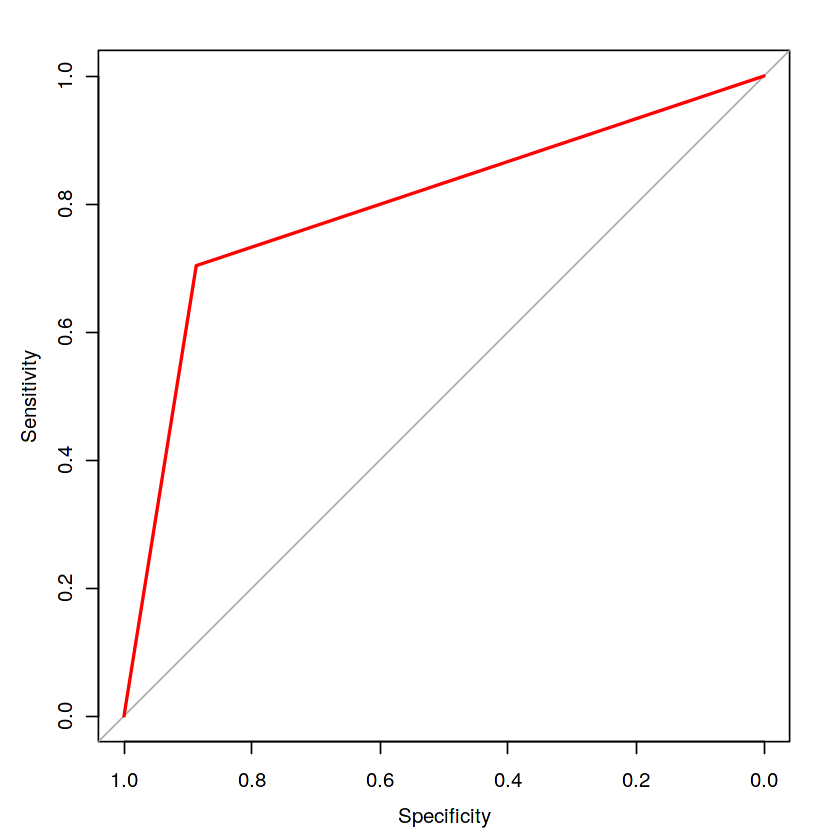

In [46]:
plot(roc(hftest$DEATH_EVENT,hftest$death_pred),col='red')

In [47]:
auc(roc(hftest$DEATH_EVENT,hftest$death_pred))

Setting levels: control = 0, case = 1

Setting direction: controls < cases



Area under the curve: 0.7954

## Regression Plot

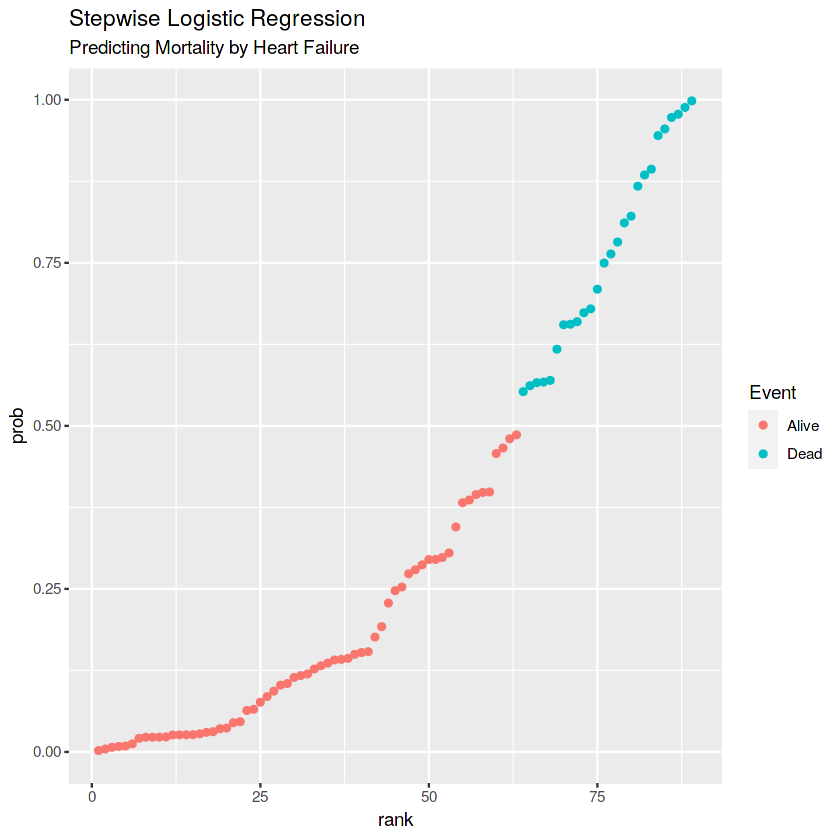

In [48]:
hftest %>% 
  arrange(prob) %>% 
  mutate(rank=rank(prob),Event=ifelse(prob>=0.5,'Dead','Alive')) %>% 
  ggplot(aes(rank,prob))+
  geom_point(aes(color=Event))+
  ggtitle('Stepwise Logistic Regression',subtitle='Predicting Mortality by Heart Failure')

In conclusion, the accuracy and AUC values for this model indicate that the stepwise logistic regression model is a decent model to predict mortality by heart disease.